In [1]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

#print("Path to dataset files:", path)

# **DATA LOADING AND NORMALIZATION**

In [2]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsummary import summary
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224

def get_training_data(data_dir):
    data = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image
                
                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# Load the data
train_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/chest_xray/train')
test_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/chest_xray/test')
val_data = get_training_data('/Users/giuliasaresini/Documents/tesi_vs/Medicine/Progetto/chest_xray/val')

## **NORMALIZE DATA**

In [4]:
from sklearn.utils import shuffle

# Function to normalize the images
def normalize_images(data):
    images = []
    labels = []
    
    for img, label in data:
        # Normalization: each pixel is divided by 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)
    
    # Convert the images and labels into separate arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Normalize the images in the training dataset
train_images, train_labels = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)

# Shuffle the training and validation data
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
val_images, val_labels = shuffle(val_images, val_labels, random_state=42)

# Check the shape and an example of the normalized and shuffled data
print(f"Shape of normalized and shuffled train images: {train_images.shape}")
print(f"Shape of normalized and shuffled validation images: {val_images.shape}")

Shape of normalized and shuffled train images: (5216, 224, 224)
Shape of normalized and shuffled validation images: (16, 224, 224)


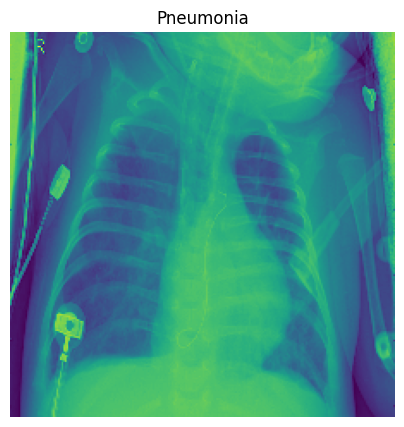

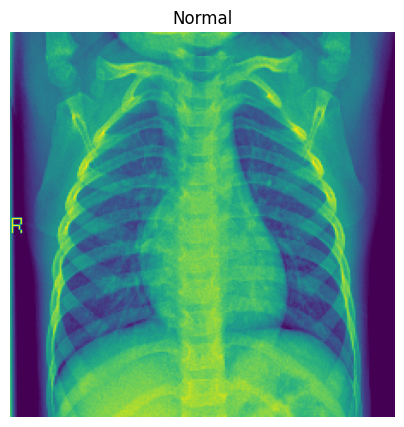

In [5]:
# Separate the images and the labels
train_images_img = np.array([x[0] for x in train_data])  # Extract only the images
train_labels_img = np.array([x[1] for x in train_data])  # Extract only the labels

# Display the first image
plt.figure(figsize=(5, 5))
plt.imshow(train_images_img[0])  # The first image
plt.title('Pneumonia' if train_labels_img[0] == 0 else 'Normal')  # Set the title based on the label
plt.axis('off')  # To hide the axes
plt.show()

# Display the last image
plt.figure(figsize=(5, 5))
plt.imshow(train_images_img[-1])  # The last image
plt.title('Pneumonia' if train_labels_img[-1] == 0 else 'Normal')  # Set the title based on the label
plt.axis('off')  # To hide the axes
plt.show()

# **DATA AUGMENTATION**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# Identify the images of the "Normal" and "Pneumonia" classes
normal_images = train_images[train_labels == 1]  # Only "Normal" images
normal_labels = train_labels[train_labels == 1]  # Corresponding labels
pneumonia_images = train_images[train_labels == 0]  # Only "Pneumonia" images
pneumonia_labels = train_labels[train_labels == 0]  # Corresponding labels

# Add a dimension for the channel (1 for grayscale images)
normal_images = np.expand_dims(normal_images, axis=-1)
pneumonia_images = np.expand_dims(pneumonia_images, axis=-1)

# Determine the number of target images to balance the dataset
target_normal_images_count = pneumonia_images.shape[0]
current_normal_images_count = normal_images.shape[0]
images_to_generate = target_normal_images_count - current_normal_images_count

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images to balance the dataset
augmented_normal_images = []
if images_to_generate > 0:
    augmented_data_gen = datagen.flow(normal_images, normal_labels, batch_size=32, shuffle=False)
    for _ in range(images_to_generate // 32 + 1):
        batch_images, _ = next(augmented_data_gen)
        augmented_normal_images.append(batch_images)

    # Concatenate all the generated images
    augmented_normal_images = np.vstack(augmented_normal_images)[:images_to_generate]
else:
    augmented_normal_images = np.empty((0, *normal_images.shape[1:]))

# Concatenate the original and augmented images for the "Normal" class
balanced_normal_images = np.concatenate([normal_images, augmented_normal_images])
balanced_normal_labels = np.full(balanced_normal_images.shape[0], 1)

# Create the final balanced dataset
augmented_train_images = np.concatenate([pneumonia_images, balanced_normal_images])
augmented_train_labels = np.concatenate([pneumonia_labels, balanced_normal_labels])

# Shuffle the dataset randomly
augmented_train_images, augmented_train_labels = shuffle(augmented_train_images, augmented_train_labels)

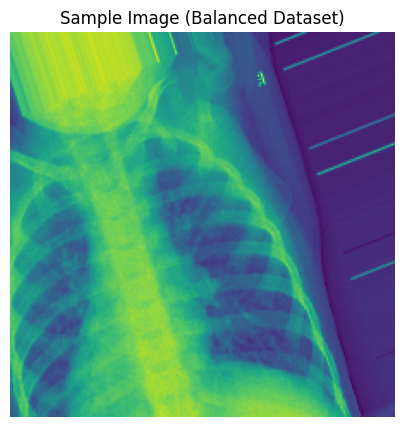

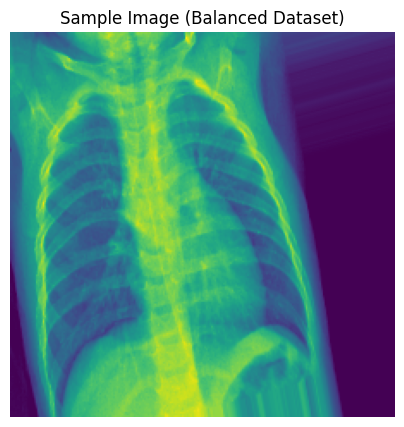

Number of Pneumonia images: 3875
Number of Normal images (original + augmented): 3875
Total number of images in the balanced dataset: 7750


In [7]:
# Display some images for confirmation
plt.figure(figsize=(5, 5))
plt.imshow(augmented_train_images[0].reshape(224, 224))
plt.title('Sample Image (Balanced Dataset)')
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(augmented_train_images[-1].reshape(224, 224))
plt.title('Sample Image (Balanced Dataset)')
plt.axis('off')
plt.show()

# Check the balance
print("Number of Pneumonia images:", pneumonia_images.shape[0])
print("Number of Normal images (original + augmented):", balanced_normal_images.shape[0])
print("Total number of images in the balanced dataset:", augmented_train_images.shape[0])

# **KAN REAL**

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torchsummary import summary
import math

# KANLinear_v1 Class (Custom Layer)
class KANLinear_v1(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, 
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0, 
                 enable_standalone_scale_spline=True, base_activation=nn.LeakyReLU, 
                 grid_eps=0.02, grid_range=[-1, 1], dropout_rate=0.2):
        super(KANLinear_v1, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h 
                 + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Regularization lambda
        self.lambda_reg = 1e-4

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5)
                     * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_(
                self.scale_spline * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise)
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x):
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k+1)]) / (grid[:, k:-1] - grid[:, :-(k+1)]) * bases[:, :, :-1]
                     + (grid[:, k+1:] - x) / (grid[:, k+1:] - grid[:, 1:-k]) * bases[:, :, 1:])
        return bases.contiguous()

    def curve2coeff(self, x, y):
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.dropout(self.b_splines(x).view(x.size(0), -1)), 
            self.spline_weight.view(self.out_features, -1)
        )
        return base_output + spline_output

# ConvNeXtKAN_v1 Model
class ConvNeXtKAN_v1(nn.Module):
    def __init__(self):
        super(ConvNeXtKAN_v1, self).__init__()
        # Parte convoluzionale sostituita
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Primo strato convoluzionale
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # MaxPooling
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),  # Secondo strato convoluzionale
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),  # Aggiunto Dropout come nella rete Keras
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # MaxPooling
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),  # Terzo strato convoluzionale
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # MaxPooling
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),  # Quarto strato convoluzionale
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),  # Aggiunto Dropout come nella rete Keras
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # MaxPooling
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),  # Quinto strato convoluzionale
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),  # Aggiunto Dropout come nella rete Keras
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # MaxPooling
            
            nn.AdaptiveAvgPool2d((1, 1))  # Riduzione adattiva delle dimensioni
        )

        self.flatten = nn.Flatten()

        # Layer KAN
        self.kan1 = KANLinear_v1(256, 512)
        self.kan2 = KANLinear_v1(512, 2)  # 2 classi (per classificazione binaria)

    def forward(self, x):
        x = self.conv_layers(x)  # Passaggio attraverso i layer convoluzionali
        x = self.flatten(x)  # Flatten dell'output convoluzionale
        x = self.kan1(x)  # Primo layer KAN
        x = self.kan2(x)  # Secondo layer KAN
        return x


# Print the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtKAN_v1().to(device)

# Print a summary of the model for 1x224x224 images (Grayscale)
summary(model, (1, 224, 224))

# Define the AdamW optimizer with L2 regularization
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Function to monitor precision and recall
def calculate_precision_recall(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    #precision = precision_score(all_labels, all_preds, average='binary', zero_division=1)
    #recall = recall_score(all_labels, all_preds, average='binary', zero_division=1)

    return precision, recall

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             288
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
           Dropout-8         [-1, 64, 112, 112]               0
         MaxPool2d-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
        MaxPool2d-13           [-1, 64, 28, 28]               0
           Conv2d-14          [-1, 128,

In [9]:
from collections import Counter

# Contare la distribuzione delle etichette
distribution = Counter(val_labels)
print(distribution)

Counter({0: 8, 1: 8})


In [10]:
from collections import Counter

# Contare la distribuzione delle etichette
distribution = Counter(augmented_train_labels)
print(distribution)


Counter({1: 3875, 0: 3875})


In [11]:
from collections import Counter

# Contare la distribuzione delle etichette
distribution = Counter(test_labels)
print(distribution)


Counter({0: 390, 1: 234})


In [12]:
val_images.shape

(16, 224, 224)

In [13]:
# Apply the transformation to training and validation images
train_images_tensor = torch.stack([torch.tensor(img) for img in augmented_train_images])
val_images_tensor = torch.stack([torch.tensor(img) for img in val_images]).unsqueeze(1)

print(val_images_tensor.shape)

# Now permute them
train_images_tensor = train_images_tensor.permute(0, 3, 1, 2)  # (N, 1, 244, 244)
val_images_tensor = val_images_tensor.permute(0, 1, 2, 3)      # (N, 1, 244, 244)
print(val_images_tensor.shape, train_images_tensor.shape)

# The tensors are now in the shape (N, 1, 244, 244), where N is the number of images

train_labels_tensor = torch.tensor(augmented_train_labels, dtype=torch.long) 
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long) 

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model and device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtKAN_v1().to(device)

# Define the loss function and optimizer (AdamW + L2 regularization)
criterion = nn.CrossEntropyLoss()  # For multi-class or binary classification
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # AdamW with L2 regularization
#criterion = nn.CrossEntropyLoss()  # For multi-class or binary classification
#optimizer = optim.AdamW(model.parameters(), lr=1e-4)  


torch.Size([16, 1, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([7750, 1, 224, 224])


In [14]:
# Function to calculate precision and recall
def calculate_precision_recall(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    
    return precision, recall

# Training function with Early Stopping
# Training function with saving of loss and accuracy values
def train_model_with_plot(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    best_val_loss = float("inf")
    epochs_without_improvement = 0  # Counter for Early Stopping
    
    # Lists to save metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Training mode
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.long).to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

        # Average training loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_preds / total_preds
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation
        model.eval()  # Evaluation mode
        val_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.long).to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Update metrics
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels).item()
                val_total_preds += labels.size(0)

        # Average validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct_preds / val_total_preds
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "best_model_g_e.pth")
            print("Model saved!")
        else:
            epochs_without_improvement += 1
            print(f"Early Stopping Counter: {epochs_without_improvement}/{patience}")

        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Stopping training.")
            break
    
    # Plotting metrics
    plt.figure(figsize=(14, 6))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Start training
train_model_with_plot(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10)

Epoch 1/100
Train Loss: 0.2216, Train Accuracy: 0.9095
Validation Loss: 2.9810, Validation Accuracy: 0.5000
Model saved!
Epoch 2/100
Train Loss: 0.1291, Train Accuracy: 0.9502
Validation Loss: 3.6202, Validation Accuracy: 0.5000
Early Stopping Counter: 1/10
Epoch 3/100
Train Loss: 0.0986, Train Accuracy: 0.9610
Validation Loss: 2.9717, Validation Accuracy: 0.5000
Model saved!
Epoch 4/100
Train Loss: 0.0831, Train Accuracy: 0.9662
Validation Loss: 3.8403, Validation Accuracy: 0.5000
Early Stopping Counter: 1/10
Epoch 5/100
Train Loss: 0.0699, Train Accuracy: 0.9734
Validation Loss: 3.3189, Validation Accuracy: 0.5000
Early Stopping Counter: 2/10
Epoch 6/100
Train Loss: 0.0638, Train Accuracy: 0.9752
Validation Loss: 5.7201, Validation Accuracy: 0.5000
Early Stopping Counter: 3/10
Epoch 7/100
Train Loss: 0.0556, Train Accuracy: 0.9788
Validation Loss: 3.9213, Validation Accuracy: 0.5000
Early Stopping Counter: 4/10
Epoch 8/100
Train Loss: 0.0501, Train Accuracy: 0.9813
Validation Loss: 2

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert them to tensors if they aren't already
test_images_tensor = torch.stack([torch.tensor(img) for img in test_images]).unsqueeze(1)  # Applying the same transformation as for train/val
test_images_tensor = test_images_tensor.permute(0, 1, 2, 3)
print(test_images_tensor.shape)

test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)  # or torch.float if binary classification

# Create the dataset and DataLoader for the test set
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Function to calculate the classification report
def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    # Generate classification report
    report = classification_report(all_labels, all_preds)
    return report

# Test the model on the test data
def test_model(model, test_loader, device):
    report = calculate_metrics(model, test_loader, device)
    print(f"Classification Report:\n{report}")

# Load the saved model (if you've already trained the model)
model = ConvNeXtKAN_v1().to(device)
model.load_state_dict(torch.load("best_model_g_e.pth"))  # Load the model with the best result

# Run the test
test_model(model, test_loader, device)


torch.Size([624, 1, 224, 224])


/var/folders/tj/7m7f0dn51772hz65_qmb34940000gn/T/ipykernel_1220/3273654726.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       390
           1       0.93      0.66      0.78       234

    accuracy                           0.86       624
   macro avg       0.88      0.82      0.83       624
weighted avg       0.87      0.86      0.85       624

